In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
!pip install optuna
!pip install datasets
import optuna
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from datetime import datetime
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 r

In [ ]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the BERT tokenizer
model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# Load dataset
df = pd.read_csv('training_all_columns.csv')  # Replace with the path to your merged CSV file
def combine_columns(row):
    title = row['title'] if pd.notna(row['title']) else ''
    body = row['body'] if pd.notna(row['body']) else ''
    return title + ' ' + body

df['text'] = df.apply(combine_columns, axis=1)

df = df[['username', 'type', 'post_id', 'title', 'body', 'subreddit', 'label', 'created_utc', 'text']]

# Split into train and test datasets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenization function
def tokenize_data(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

# Convert pandas dataframes to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize_data, batched=True)
test_dataset = test_dataset.map(tokenize_data, batched=True)

# Remove unnecessary columns

train_dataset = train_dataset.remove_columns(['text', 'username', 'type', 'post_id', 'title', 'body', 'subreddit', 'created_utc']).rename_column("label", "labels")
test_dataset_for_eval = test_dataset.remove_columns(['text', 'username', 'type', 'post_id', 'title', 'body', 'subreddit', 'created_utc']).rename_column("label", "labels")
train_dataset.set_format("torch")
test_dataset_for_eval.set_format("torch")

# Define the compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = torch.argmax(torch.tensor(pred.predictions), dim=1).numpy()

    # Standard metrics
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()

    # Add predictions to the test dataframe for evaluation
    test_df['preds'] = preds
    test_df['evaluation'] = [
        'TP' if p == 1 and l == 1 else
        'FP' if p == 1 and l == 0 else
        'TN' if p == 0 and l == 0 else
        'FN'
        for p, l in zip(preds, labels)
    ]
    test_df.to_csv('test_with_predictions.csv', index=False)  # Save the updated test dataset

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_positives': tp,
        'false_positives': fp,
        'true_negatives': tn,
        'false_negatives': fn
    }

# Use best parameters from Optuna
best_params = {
    'learning_rate': 1.4145760631193807e-05,
    'batch_size': 32,
    'num_train_epochs': 3,
    'weight_decay': 0.01
}

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='no',  # Do not evaluate during training
    save_strategy='epoch',        # Only save the final model
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    num_train_epochs=best_params['num_train_epochs'],
    weight_decay=best_params['weight_decay'],
    learning_rate=best_params['learning_rate'],
    logging_dir='./logs',
    report_to=[],  # Disable reporting
)

# Initialize and train the model
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset_for_eval,
    compute_metrics=compute_metrics
)

trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/25022 [00:00<?, ? examples/s]

Map:   0%|          | 0/6256 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.614900
1000,0.569700
1500,0.530700
2000,0.457100


Evaluation Results: {'eval_loss': 0.59333336353302, 'eval_accuracy': 0.69693094629156, 'eval_precision': 0.6857847671908727, 'eval_recall': 0.7171880038697195, 'eval_f1': 0.7011349306431274, 'eval_true_positives': 2224, 'eval_false_positives': 1019, 'eval_true_negatives': 2136, 'eval_false_negatives': 877, 'eval_runtime': 36.779, 'eval_samples_per_second': 170.097, 'eval_steps_per_second': 5.329, 'epoch': 3.0}


In [ ]:

!zip -r results.zip ./results/

from google.colab import files
files.download('results.zip')
files.download('test_with_predictions.csv')

  adding: results/ (stored 0%)
  adding: results/checkpoint-1564/ (stored 0%)
  adding: results/checkpoint-1564/trainer_state.json (deflated 58%)
  adding: results/checkpoint-1564/config.json (deflated 49%)
  adding: results/checkpoint-1564/training_args.bin (deflated 51%)
  adding: results/checkpoint-1564/optimizer.pt (deflated 14%)
  adding: results/checkpoint-1564/rng_state.pth (deflated 25%)
  adding: results/checkpoint-1564/scheduler.pt (deflated 56%)
  adding: results/checkpoint-1564/model.safetensors (deflated 7%)
  adding: results/checkpoint-2346/ (stored 0%)
  adding: results/checkpoint-2346/trainer_state.json (deflated 60%)
  adding: results/checkpoint-2346/config.json (deflated 49%)
  adding: results/checkpoint-2346/training_args.bin (deflated 51%)
  adding: results/checkpoint-2346/optimizer.pt (deflated 14%)
  adding: results/checkpoint-2346/rng_state.pth (deflated 25%)
  adding: results/checkpoint-2346/scheduler.pt (deflated 56%)
  adding: results/checkpoint-2346/model.saf

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-16-726e0cb6cd7d>:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(index, value + std_error[index] + 0.5, f'{value:.2f}', ha='center', fontsize=10)


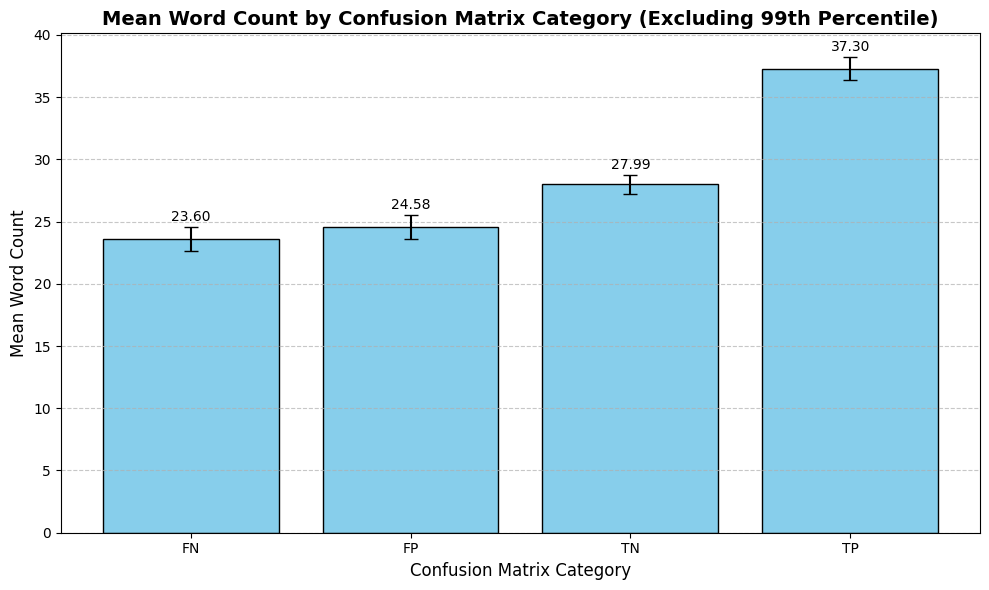

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
file_path = 'test_with_predictions.csv'
data = pd.read_csv(file_path)

# Ensure 'evaluation' and 'text' columns are present
if 'evaluation' not in data.columns or 'text' not in data.columns:
    raise ValueError("The CSV file must contain 'evaluation' and 'text' columns.")

# Calculate word count for each row
data['word_count'] = data['text'].apply(lambda x: len(str(x).split()))

# Exclude the 99th percentile of word counts
threshold = np.percentile(data['word_count'], 99)
data_filtered = data[data['word_count'] <= threshold]

# Group by evaluation category and calculate the mean and standard error of the word count
mean_word_counts = data_filtered.groupby('evaluation')['word_count'].mean()
std_error = data_filtered.groupby('evaluation')['word_count'].sem()

# Plot the mean word count with error bars for each confusion matrix category
plt.figure(figsize=(10, 6))
bar_plot = plt.bar(mean_word_counts.index, mean_word_counts, yerr=std_error, color='skyblue', edgecolor='black', capsize=5)
plt.title('Mean Word Count by Confusion Matrix Category (Excluding 99th Percentile)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Word Count', fontsize=12)
plt.xlabel('Confusion Matrix Category', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the mean values above each bar
for index, value in enumerate(mean_word_counts):
    plt.text(index, value + std_error[index] + 0.5, f'{value:.2f}', ha='center', fontsize=10)

plt.tight_layout()

# Show the plot
plt.show()